<h1 style=font-size:40px>Predicting Material Backorders in Inventory Management</h1>

In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, auc
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('preprocessed_train.csv')
test = pd.read_csv('preprocessed_test.csv')

In [3]:
train.head(2)

,Unnamed: 0,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,binary_pieces_past_due,binary_local_bo_qty
0,0,0.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-99.00,0.0,0.764874,0.993169,0.873587,0.957397,0.992876,0,0,0
1,1,2.0,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.99,0.0,0.764874,0.993169,0.873587,0.957397,0.992876,0,0,0


In [4]:
test.head(2)

,Unnamed: 0,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,binary_pieces_past_due,binary_local_bo_qty
0,0,62.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-99.0,0.0,0.228435,0.993169,0.873587,0.957397,0.992876,0,0,0
1,1,9.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-99.0,0.0,0.764874,0.993169,0.119723,0.035912,0.992876,0,0,0


In [5]:
train.drop('Unnamed: 0', axis=1, inplace=True)
test.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
train.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,binary_pieces_past_due,binary_local_bo_qty
0,0.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-99.00,0.0,0.764874,0.993169,0.873587,0.957397,0.992876,0,0,0
1,2.0,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.99,0.0,0.764874,0.993169,0.873587,0.957397,0.992876,0,0,0
2,2.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-99.00,0.0,0.228435,0.993169,0.873587,0.957397,0.992876,0,0,0
3,7.0,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.13,0.0,0.764874,0.993169,0.873587,0.957397,0.992876,0,0,0
4,8.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,-99.00,0.0,0.228435,0.993169,0.873587,0.957397,0.992876,0,0,0


In [7]:
test.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,binary_pieces_past_due,binary_local_bo_qty
0,62.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-99.00,0.0,0.228435,0.993169,0.873587,0.957397,0.992876,0,0,0
1,9.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-99.00,0.0,0.764874,0.993169,0.119723,0.035912,0.992876,0,0,0
2,17.0,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.95,0.0,0.764874,0.993169,0.873587,0.957397,0.992876,0,0,0
3,9.0,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.75,0.0,0.764874,0.993169,0.119723,0.957397,0.992876,0,0,0
4,2.0,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.71,0.0,0.764874,0.993169,0.873587,0.957397,0.992876,0,0,0


In [8]:
y_train = train['went_on_backorder']

In [9]:
x_train = train.drop('went_on_backorder', axis=1)

In [10]:
y_test = test['went_on_backorder']

In [11]:
x_test = test.drop('went_on_backorder', axis=1)

In [12]:
print(f'x_train: {x_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'x_test: {x_test.shape}')
print(f'y_test: {y_test.shape}')

x_train: (1687860, 23)
y_train: (1687860,)
x_test: (242075, 23)
y_test: (242075,)


# Logistic Regression

In [45]:
robust_scaler = RobustScaler()

In [46]:
x_train_scaled = robust_scaler.fit_transform(x_train)

In [47]:
x_test_scaled = robust_scaler.transform(x_test)

In [48]:
logistic_regression = SGDClassifier(loss='log', class_weight='balanced', n_jobs=-1)

In [49]:
params = {'eta0': [0.1, 0.01, 0.001, 0.0001, 1e-5, 1e-6, 1e-7], 'penalty': ['l1', 'l2']}

In [50]:
logist_grid_search = GridSearchCV(logistic_regression, params, cv=5, n_jobs=-1, scoring='accuracy', return_train_score=True)

In [51]:
logist_grid_search.fit(x_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=SGDClassifier(class_weight='balanced', loss='log',
                                     n_jobs=-1),
             n_jobs=-1,
             param_grid={'eta0': [0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06,
                                  1e-07],
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='accuracy')

In [52]:
best_eta0 = logist_grid_search.best_estimator_.eta0

In [53]:
best_penalty = logist_grid_search.best_estimator_.penalty

In [54]:
best_logist = SGDClassifier(loss='log', learning_rate='constant', eta0=best_eta0, penalty=best_penalty, class_weight='balanced', n_jobs=-1)

In [55]:
best_logist.fit(x_train_scaled, y_train)

SGDClassifier(class_weight='balanced', eta0=0.001, learning_rate='constant',
              loss='log', n_jobs=-1, penalty='l1')

In [56]:
logist_y_pred_train = best_logist.predict(x_train_scaled)
logist_y_pred = best_logist.predict(x_test_scaled)

In [57]:
print('The accuracy score of the logistic regression model on train set is:', accuracy_score(y_train, logist_y_pred_train))
print('The accuracy score of the logistic regression model on test set is:', accuracy_score(y_test, logist_y_pred))

The accuracy score of the logistic regression model on train set is: 0.8023408339554229
The accuracy score of the logistic regression model on test set is: 0.798430238562429


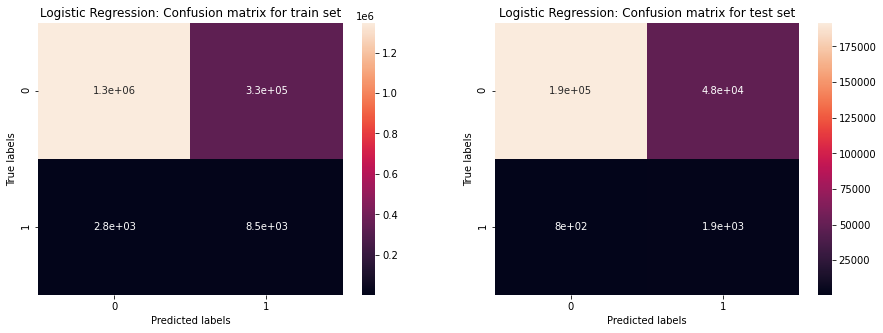

In [58]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_train, logist_y_pred_train), annot=True)
plt.title('Logistic Regression: Confusion matrix for train set')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, logist_y_pred), annot=True)
plt.title('Logistic Regression: Confusion matrix for test set')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [59]:
print('The precision score the best logistic regression model on train set is:', precision_score(y_train, logist_y_pred_train, average='macro'))
print('The precision score the best logistic regression model on test set is:', precision_score(y_test, logist_y_pred, average='macro'))

The precision score the best logistic regression model on train set is: 0.5114060281441166
The precision score the best logistic regression model on test set is: 0.5168904036883744


In [60]:
print('The recall score the best logistic regression model on train set is:', recall_score(y_train, logist_y_pred_train, average='macro'))
print('The recall score the best logistic regression model on test set is:', recall_score(y_test, logist_y_pred, average='macro'))

The recall score the best logistic regression model on train set is: 0.7756100808401734
The recall score the best logistic regression model on test set is: 0.7516805417637151


In [65]:
print('The AUC score the best logistic regression model on train set is:', roc_auc_score(y_train, logist_y_pred_train, average='macro'))
print('The AUC score the best logistic regression model on test set is:', roc_auc_score(y_test, logist_y_pred, average='macro'))

The AUC score the best logistic regression model on train set is: 0.7756100808401734
The AUC score the best logistic regression model on test set is: 0.7516805417637152


In [62]:
logist_y_train_pred = best_logist.predict_proba(x_train_scaled)[:,1]
logist_y_test_pred = best_logist.predict_proba(x_test_scaled)[:,1]

In [63]:
train_fpr_logist, train_tpr_logist, train_thresholds_logist = roc_curve(y_train, logist_y_train_pred)
test_fpr_logist, test_tpr_logist, test_thresholds_logist = roc_curve(y_test, logist_y_test_pred)

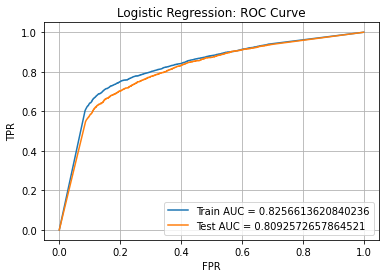

In [64]:
plt.plot(train_fpr_logist, train_tpr_logist, label="Train AUC ="+' '+str(auc(train_fpr_logist, train_tpr_logist)))
plt.plot(test_fpr_logist, test_tpr_logist, label="Test AUC ="+' '+str(auc(test_fpr_logist, test_tpr_logist)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Logistic Regression: ROC Curve")
plt.grid()
plt.show()

# Decision Tree

In [82]:
cart = DecisionTreeClassifier(criterion='gini', class_weight='balanced')

In [83]:
params = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}

In [85]:
cart_grid_search = GridSearchCV(cart, params, cv=5, n_jobs=-1, scoring='roc_auc', return_train_score=True)

In [86]:
cart_grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15]},
             return_train_score=True, scoring='roc_auc')

In [87]:
best_max_depth_cart = cart_grid_search.best_estimator_.max_depth

In [110]:
best_cart = DecisionTreeClassifier(criterion='gini', max_depth=best_max_depth_cart, class_weight='balanced')

In [111]:
best_cart.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=8)

In [112]:
cart_y_pred_train = best_cart.predict(x_train)
cart_y_pred = best_cart.predict(x_test)

In [113]:
print('The accuracy score of the decision tree model on train set is:', accuracy_score(y_train, cart_y_pred_train))
print('The accuracy score of the decision tree model on test set is:', accuracy_score(y_test, cart_y_pred))

The accuracy score of the decision tree model on train set is: 0.8645657815221641
The accuracy score of the decision tree model on test set is: 0.8729980377982031


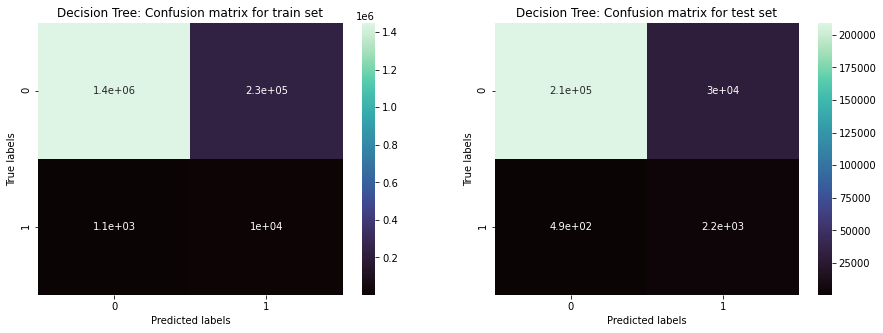

In [114]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_train, cart_y_pred_train), annot=True, cmap='mako')
plt.title('Decision Tree: Confusion matrix for train set')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, cart_y_pred), annot=True, cmap='mako')
plt.title('Decision Tree: Confusion matrix for test set')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [115]:
print('The precision score the best decision tree model on train set is:', precision_score(y_train, cart_y_pred_train, average='macro'))
print('The precision score the best decision tree model on test set is:', precision_score(y_test, cart_y_pred, average='macro'))

The precision score the best decision tree model on train set is: 0.5211217424892802
The precision score the best decision tree model on test set is: 0.5327123298788503


In [116]:
print('The recall score the best decision tree model on train set is:', recall_score(y_train, cart_y_pred_train, average='macro'))
print('The recall score the best decision tree model on test set is:', recall_score(y_test, cart_y_pred, average='macro'))

The recall score the best decision tree model on train set is: 0.8845954794088201
The recall score the best decision tree model on test set is: 0.8458475239995429


In [117]:
print('The AUC score the best decision tree model on train set is:', roc_auc_score(y_train, cart_y_pred_train, average='macro'))
print('The AUC score the best decision tree model on test set is:', roc_auc_score(y_test, cart_y_pred, average='macro'))

The AUC score the best decision tree model on train set is: 0.8845954794088201
The AUC score the best decision tree model on test set is: 0.8458475239995429


In [118]:
cart_y_train_pred = best_cart.predict_proba(x_train)[:,1]
cart_y_test_pred = best_cart.predict_proba(x_test)[:,1]

In [119]:
train_fpr_cart, train_tpr_cart, train_thresholds_cart = roc_curve(y_train, cart_y_train_pred)
test_fpr_cart, test_tpr_cart, test_thresholds_cart = roc_curve(y_test, cart_y_test_pred)

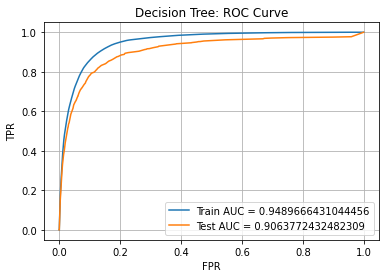

In [120]:
plt.plot(train_fpr_cart, train_tpr_cart, label="Train AUC ="+' '+str(auc(train_fpr_cart, train_tpr_cart)))
plt.plot(test_fpr_cart, test_tpr_cart, label="Test AUC ="+' '+str(auc(test_fpr_cart, test_tpr_cart)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Decision Tree: ROC Curve")
plt.grid()
plt.show()

# Random Forest

In [86]:
#smote = SMOTE()

In [87]:
#x_train, y_train = smote.fit_resample(x_train, y_train)

In [123]:
random_forest = RandomForestClassifier(criterion='gini', n_jobs=-1, class_weight='balanced_subsample')

In [124]:
params = {'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 75, 100], 
          'max_depth':[None, 2, 5, 7, 9, 10, 12, 15, 17, 20, 30, 50]}

In [125]:
forest_random_search = RandomizedSearchCV(random_forest, params, cv=5, n_jobs=-1, scoring='roc_auc', return_train_score=True)

In [126]:
forest_random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                    n_jobs=-1),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 2, 5, 7, 9, 10, 12,
                                                      15, 17, 20, 30, 50],
                                        'n_estimators': [5, 10, 15, 20, 25, 30,
                                                         35, 40, 45, 50, 75,
                                                         100]},
                   return_train_score=True, scoring='roc_auc')

In [127]:
best_n_estimators_rf = forest_random_search.best_estimator_.n_estimators

In [128]:
best_max_depth_rf = forest_random_search.best_estimator_.max_depth

In [165]:
best_forest = RandomForestClassifier(criterion='gini', n_estimators=best_n_estimators_rf, max_depth=best_max_depth_rf, 
                                     class_weight='balanced_subsample', min_samples_leaf=10, min_samples_split=10, n_jobs=-1)

In [166]:
best_forest.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       min_samples_leaf=10, min_samples_split=10,
                       n_estimators=50, n_jobs=-1)

In [167]:
forest_y_pred_train = best_forest.predict(x_train)
forest_y_pred = best_forest.predict(x_test)

In [168]:
print('The accuracy score of the random forest model on train set is:', accuracy_score(y_train, forest_y_pred_train))
print('The accuracy score of the random forest model on test set is:', accuracy_score(y_test, forest_y_pred))

The accuracy score of the random forest model on train set is: 0.934951950991196
The accuracy score of the random forest model on test set is: 0.9381927088712176


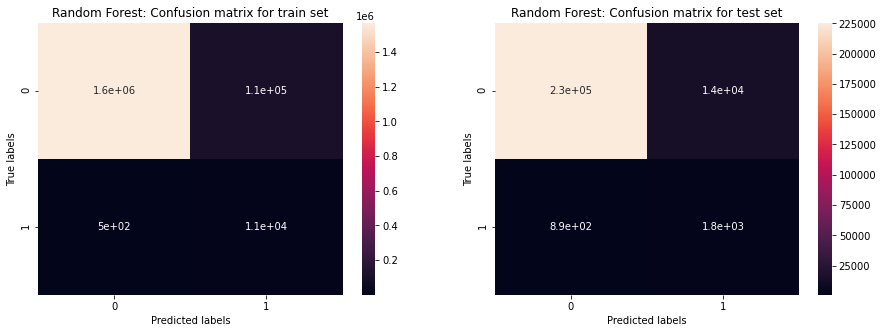

In [169]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_train, forest_y_pred_train), annot=True)
plt.title('Random Forest: Confusion matrix for train set')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, forest_y_pred), annot=True)
plt.title('Random Forest: Confusion matrix for test set')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [170]:
print('The precision score the best random forest model on train set is:', precision_score(y_train, forest_y_pred_train, average='macro'))
print('The precision score the best random forest model on test set is:', precision_score(y_test, forest_y_pred, average='macro'))

The precision score the best random forest model on train set is: 0.5447832738107107
The precision score the best random forest model on test set is: 0.5547867121834514


In [171]:
print('The recall score the best random forest model on train set is:', recall_score(y_train, forest_y_pred_train, average='macro'))
print('The recall score the best random forest model on test set is:', recall_score(y_test, forest_y_pred, average='macro'))

The recall score the best random forest model on train set is: 0.9453123844098146
The recall score the best random forest model on test set is: 0.8057933596440869


In [172]:
print('The AUC score the best random forest model on train set is:', roc_auc_score(y_train, forest_y_pred_train, average='macro'))
print('The AUC score the best random forest model on test set is:', roc_auc_score(y_test, forest_y_pred, average='macro'))

The AUC score the best random forest model on train set is: 0.9453123844098146
The AUC score the best random forest model on test set is: 0.8057933596440869


In [173]:
forest_y_train_pred = best_forest.predict_proba(x_train)[:,1]
forest_y_test_pred = best_forest.predict_proba(x_test)[:,1]

In [174]:
train_fpr_forest, train_tpr_forest, train_thresholds_forest = roc_curve(y_train, forest_y_train_pred)
test_fpr_forest, test_tpr_forest, test_thresholds_forest = roc_curve(y_test, forest_y_test_pred)

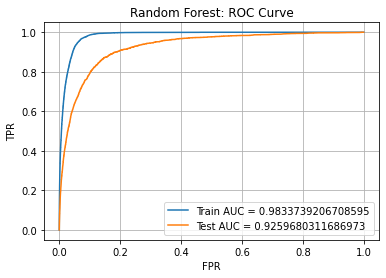

In [175]:
plt.plot(train_fpr_forest, train_tpr_forest, label="Train AUC ="+' '+str(auc(train_fpr_forest, train_tpr_forest)))
plt.plot(test_fpr_forest, test_tpr_forest, label="Test AUC ="+' '+str(auc(test_fpr_forest, test_tpr_forest)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Random Forest: ROC Curve")
plt.grid()
plt.show()

# Gradient Boosted Decision Tree

In [177]:
gbdt = XGBClassifier(learning_rate=1e-5, scale_pos_weight=148.0, n_jobs=-1)

In [178]:
params = {'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 75, 100], 
          'max_depth':[2, 3, 5, 7, 9, 10, 12, 15, 17, 20, 30, 50]}

In [179]:
gbdt_random_search = RandomizedSearchCV(gbdt, params, cv=5, n_jobs=-1, scoring='roc_auc', return_train_score=True)

In [180]:
gbdt_random_search.fit(x_train, y_train)

[13:39:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=1e-05,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                           

In [181]:
best_n_estimators_gbdt = gbdt_random_search.best_estimator_.n_estimators

In [182]:
best_max_depth_gbdt = gbdt_random_search.best_estimator_.max_depth

In [185]:
best_gbdt = XGBClassifier(n_estimators=best_n_estimators_gbdt, max_depth=best_max_depth_gbdt, learning_rate=1e-6,
                          reg_lambda=0.3, min_child_weight=0.10, subsample=0.6, colsample_bytree=0.7, n_jobs=-1)

In [186]:
best_gbdt.fit(x_train, y_train)

[14:00:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=1e-06, max_delta_step=0, max_depth=50,
              min_child_weight=0.1, missing=nan, monotone_constraints='()',
              n_estimators=30, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=0.3, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [187]:
gbdt_y_pred_train = best_gbdt.predict(x_train)
gbdt_y_pred = best_gbdt.predict(x_test)

In [188]:
print('The accuracy score of the gradient boosted decision tree model on train set is:', accuracy_score(y_train, gbdt_y_pred_train))
print('The accuracy score of the gradient boosted decision tree model on test set is:', accuracy_score(y_test, gbdt_y_pred))

The accuracy score of the gradient boosted decision tree model on train set is: 0.9953218868863531
The accuracy score of the gradient boosted decision tree model on test set is: 0.988904265207064


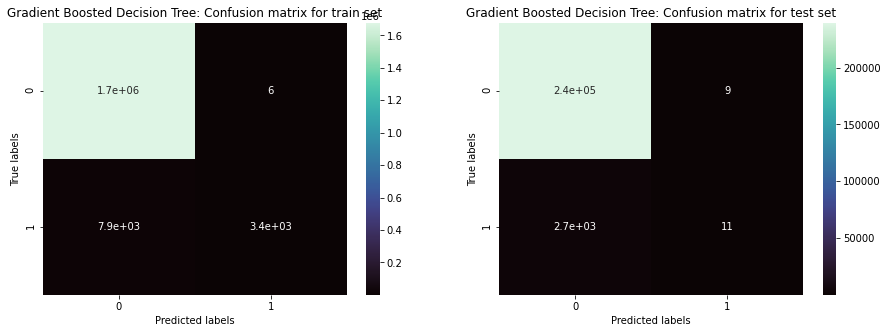

In [189]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_train, gbdt_y_pred_train), annot=True, cmap='mako')
plt.title('Gradient Boosted Decision Tree: Confusion matrix for train set')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, gbdt_y_pred), annot=True, cmap='mako')
plt.title('Gradient Boosted Decision Tree: Confusion matrix for test set')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [196]:
print('The precision score the best gradient boosted decision tree model on train set is:', precision_score(y_train, gbdt_y_pred_train, average='macro'))
print('The precision score the best gradient boosted decision tree model on test set is:', precision_score(y_test, gbdt_y_pred, average='macro'))

The precision score the best gradient boosted decision tree model on train set is: 0.9967779671777308
The precision score the best gradient boosted decision tree model on test set is: 0.7694702650224123


In [197]:
print('The recall score the best gradient boosted decision tree model on train set is:', recall_score(y_train, gbdt_y_pred_train, average='macro'))
print('The recall score the best gradient boosted decision tree model on test set is:', recall_score(y_test, gbdt_y_pred, average='macro'))

The recall score the best gradient boosted decision tree model on train set is: 0.6506667663717156
The recall score the best gradient boosted decision tree model on test set is: 0.502027332939122


In [198]:
print('The AUC score the best gradient boosted decision tree model on train set is:', roc_auc_score(y_train, gbdt_y_pred_train, average='macro'))
print('The AUC score the best gradient boosted decision tree model on test set is:', roc_auc_score(y_test, gbdt_y_pred, average='macro'))

The AUC score the best gradient boosted decision tree model on train set is: 0.6506667663717157
The AUC score the best gradient boosted decision tree model on test set is: 0.502027332939122


In [193]:
gbdt_y_train_pred = best_gbdt.predict_proba(x_train)[:,1]
gbdt_y_test_pred = best_gbdt.predict_proba(x_test)[:,1]

In [194]:
train_fpr_gbdt, train_tpr_gbdt, train_thresholds_gbdt = roc_curve(y_train, gbdt_y_train_pred)
test_fpr_gbdt, test_tpr_gbdt, test_thresholds_gbdt = roc_curve(y_test, gbdt_y_test_pred)

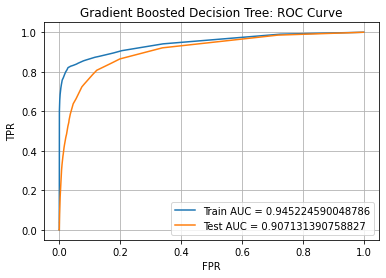

In [195]:
plt.plot(train_fpr_gbdt, train_tpr_gbdt, label="Train AUC ="+' '+str(auc(train_fpr_gbdt, train_tpr_gbdt)))
plt.plot(test_fpr_gbdt, test_tpr_gbdt, label="Test AUC ="+' '+str(auc(test_fpr_gbdt, test_tpr_gbdt)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Gradient Boosted Decision Tree: ROC Curve")
plt.grid()
plt.show()

# Saving best model

We have built 4 models for this case study i.e, Logistic Regression, Decision Tree, Random Forest and Gradient Boosted Decision Tree. Among them we see that Random Forest and Gradient Boosted Decision Tree are the best performing models. Both of them are giving us a perfect score on all the metrics. Therefore, we can finalize either of the models as our best model. For this case study, we are choosing Gradient Boosted Decision Trees as our best model.

In [202]:
filename = 'best_model_forest.h5'
pickle.dump(best_forest, open(filename, 'wb'))

In [205]:
best_model = pickle.load(open(filename, 'rb'))

In [206]:
best_model.predict(x_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [207]:
accuracy_score(y_test, best_model.predict(x_test))

0.9381927088712176

In [208]:
y_pred = best_model.predict_proba(x_test)[:,1]

In [209]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [212]:
auc(fpr, tpr)

0.9259680311686973

# Summary

In [199]:
from prettytable import PrettyTable

summary = PrettyTable()

summary.field_names = ["Model", "Hyperparameters", "Best Value", "Accuracy", "Precision", "Recall", "AUC"]
summary.add_row(['Logistic Regression', 'eta0/penalty', [best_eta0, best_penalty],
                 round(accuracy_score(y_test, logist_y_pred), 3), 
                 round(precision_score(y_test, logist_y_pred), 3), 
                 round(recall_score(y_test, logist_y_pred), 3), 
                 round(auc(test_fpr_logist, test_tpr_logist), 3)])
summary.add_row(['Decision Tree', 'max_depth', best_max_depth_cart,
                 round(accuracy_score(y_test, cart_y_pred), 3), 
                 round(precision_score(y_test, cart_y_pred), 3), 
                 round(recall_score(y_test, cart_y_pred), 3), 
                 round(auc(test_fpr_cart, test_tpr_cart), 3)])
summary.add_row(['Random Forest', 'n_estimators/max_depth', [best_n_estimators_rf, best_max_depth_rf],
                 round(accuracy_score(y_test, forest_y_pred), 3), 
                 round(precision_score(y_test, forest_y_pred), 3), 
                 round(recall_score(y_test, forest_y_pred), 3), 
                 round(auc(test_fpr_forest, test_tpr_forest), 3)])
summary.add_row(['Gradient Boosted Decision Tree', 'n_estimators/max_depth', [best_n_estimators_gbdt, best_max_depth_gbdt], 
                 round(accuracy_score(y_test, gbdt_y_pred), 3), 
                 round(precision_score(y_test, gbdt_y_pred), 3), 
                 round(recall_score(y_test, gbdt_y_pred), 3), 
                 round(auc(test_fpr_gbdt, test_tpr_gbdt), 3)])
print(summary)

+--------------------------------+------------------------+---------------+----------+-----------+--------+-------+
|             Model              |    Hyperparameters     |   Best Value  | Accuracy | Precision | Recall |  AUC  |
+--------------------------------+------------------------+---------------+----------+-----------+--------+-------+
|      Logistic Regression       |      eta0/penalty      | [0.001, 'l1'] |  0.798   |   0.038   | 0.704  | 0.809 |
|         Decision Tree          |       max_depth        |       8       |  0.873   |   0.068   | 0.818  | 0.906 |
|         Random Forest          | n_estimators/max_depth |    [50, 15]   |  0.938   |   0.113   |  0.67  | 0.926 |
| Gradient Boosted Decision Tree | n_estimators/max_depth |    [30, 50]   |  0.989   |    0.55   | 0.004  | 0.907 |
+--------------------------------+------------------------+---------------+----------+-----------+--------+-------+


We see that tree based models perform way better than linear models. Ensemble models like Random Forest and Gradient Boosted Decision Trees performed the best. We see that the best model is Random Forest model with an AUC of 0.926